In [1]:
!pip install openflexure_microscope_client

     |████████████████████████████████| 66 kB 3.7 MB/s eta 0:00:011
     |████████████████████████████████| 2.2 MB 8.9 MB/s eta 0:00:01
  Attempting uninstall: Pillow
    Found existing installation: Pillow 8.1.1
    Uninstalling Pillow-8.1.1:
      Successfully uninstalled Pillow-8.1.1
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [21]:
import openflexure_microscope_client as ofm_client
import matplotlib.pyplot as plt
import numpy as np
import io
import requests
import time
from PIL import Image
import json

In [3]:
microscope = ofm_client.MicroscopeClient("microscope")
microscope.base_uri

'http://microscope:5000/api/v2'

In [4]:
pos = microscope.position
starting_pos = pos.copy()
pos['x'] += 100
microscope.move(pos)
assert microscope.position == pos
pos['x'] -= 100
microscope.move(pos)
assert microscope.position == starting_pos

# Check the microscope will autofocus
ret = microscope.autofocus()

#print(image.metadata)
print("Active microscope extensions")
for k in microscope.extensions.keys():
    print(k)

Active microscope extensions
org.openflexure.autofocus
org.openflexure.scan
org.openflexure.zipbuilder
org.openflexure.autostorage
org.openflexure.calibration.picamera
org.openflexure.camera_stage_mapping


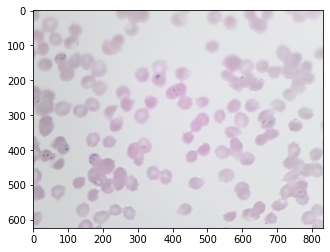

In [5]:
# Acquire an image for sanity-checking too
image = microscope.grab_image()
f, ax = plt.subplots(1,1)
ax.imshow(np.array(image))

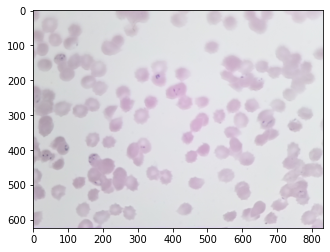

In [6]:
# Acquire an image for sanity-checking too
image = microscope.capture_image()
f, ax = plt.subplots(1,1)
ax.imshow(np.array(image))

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 446, in _make_request
    assert_header_parsing(httplib_response.msg)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/response.py", line 71, in assert_header_parsing
    raise HeaderParsingError(defects=defects, unparsed_data=unparsed_data)
urllib3.exceptions.HeaderParsingError: [StartBoundaryNotFoundDefect(), MultipartInvariantViolationDefect()], unparsed data: ''


61

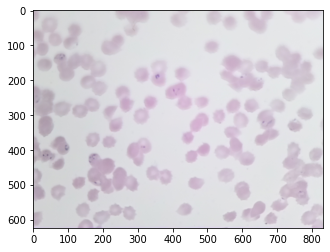

In [7]:
# Streaming
b = microscope.grab_mjpeg(2)
frames_found = 0
for image in ofm_client.iterate_mjpeg_images(b):
    plt.imshow(image)
    frames_found += 1
assert frames_found > 0
frames_found

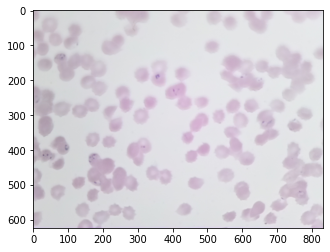

In [8]:
image = microscope.grab_image_array()
f, ax = plt.subplots(1,1)
ax.imshow(np.array(image))

In [9]:
image.shape

(624, 832, 3)

(624, 832, 3)


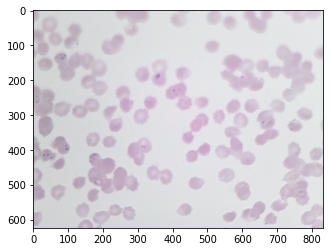

In [10]:
import PIL.Image
import io
microscope.autofocus()
r_content = microscope.grab_image_raw()
image = PIL.Image.open(io.BytesIO(r_content))
f, ax = plt.subplots(1,1)
print(np.asarray(image).shape)
ax.imshow(np.array(image))

In [11]:
x, y, z = microscope.get_position_array()
z

1910

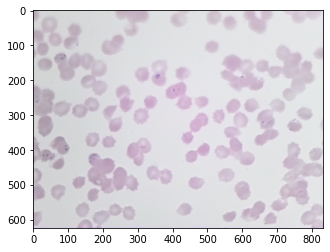

In [12]:
microscope.move([0,200,1688])
microscope.extensions["org.openflexure.autofocus"]["autofocus"].post_json()
image = microscope.grab_image_array()
f, ax = plt.subplots(1,1)
ax.imshow(np.array(image))

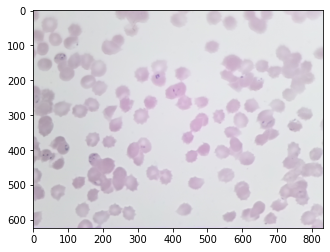

In [13]:
microscope.laplacian_autofocus({'autofocus_dz': 20})
image = microscope.grab_image_array()
f, ax = plt.subplots(1,1)
ax.imshow(np.array(image))

In [79]:
base_uri = microscope.base_uri
def capture_full_resolution_image(base_uri, params: dict = None):
    """Capture an image and return it as a image """
    payload = {
        "use_video_port": False,
        "bayer": False,
    }
    if params:
        payload.update(params)
    r = requests.post(base_uri + "/actions/camera/capture", json=payload, headers={'Accept': 'image/jpeg'}, timeout =60)
    r.raise_for_status()
    action_href = json.loads(r.content.decode('utf-8'))['href']
    time.sleep(2)
    r = requests.get(action_href)
    if json.loads(r.content.decode('utf-8'))['output'] is not None:
        r = requests.get(json.loads(r.content.decode('utf-8'))['output']['links']['download']['href'])
        image = np.array(Image.open(io.BytesIO(r.content)))
        return image
    else:
        time.sleep(2)
        if json.loads(r.content.decode('utf-8'))['output'] is not None:
            r = requests.get(json.loads(r.content.decode('utf-8'))['output']['links']['download']['href'])
            image = np.array(Image.open(io.BytesIO(r.content)))
            return image

In [90]:
# Acquire an image for sanity-checking too
image = 0
image = capture_full_resolution_image(base_uri)
f, ax = plt.subplots(1,1)
ax.imshow(image)
data = Image.fromarray(image)
      
# saving the final output 
# as a PNG file
data.save("../data/testing_openflexure/full_resolution_client_test.png")

AttributeError: module 'cellpose.io' has no attribute 'BytesIO'

In [85]:
np.array(image).shape

(2464, 3280, 3)

In [86]:
import cellpose
from cellpose import utils, io, models, plot
from cellpose.utils import outlines_list, masks_to_outlines

In [87]:
model = models.Cellpose(gpu=True, model_type='cyto')

** TORCH CUDA version installed and working. **
>>>> using GPU


In [88]:
chan = [0, 0] # for black and white imgs
#img = io.imread(filename)
masks, flows, styles, diams = model.eval(image, 
                             diameter= 190, 
                             channels=chan,
                             invert = True,
                             flow_threshold = 1,
                             #cellprob_threshold = -2,
                                            )


processing 1 image(s)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3829: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


time spent: running network 0.59s; flow+mask computation 0.90
estimated masks for 1 image(s) in 1.94 sec
>>>> TOTAL TIME 1.94 sec


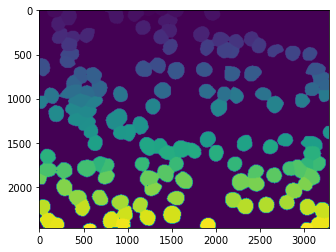

In [89]:
plt.imshow(masks)

In [17]:
r = requests.get("http://microscope:5000/api/v2/actions/bb7e86c1-9aaf-4f3c-ba66-38d81037901d")

In [18]:
print(type(r.content))
print(bytes(r.content))

<class 'bytes'>
b'{"action": "CaptureAPI", "log": [{"filename": "config.py", "name": "root", "created": "2021-05-07T08:38:29.859465", "message": "Loading /var/openflexure/settings/microscope_settings.json...", "lineno": 89, "levelno": 20, "levelname": "INFO"}, {"filename": "config.py", "name": "root", "created": "2021-05-07T08:38:29.870377", "message": "Loading /var/openflexure/settings/microscope_configuration.json...", "lineno": 89, "levelno": 20, "levelname": "INFO"}, {"filename": "microscope.py", "name": "root", "created": "2021-05-07T08:38:29.910231", "message": "Starting microscope capture /var/openflexure/data/micrographs/2021-05-07_08-38-29.jpeg", "lineno": 393, "levelno": 20, "levelname": "INFO"}, {"filename": "pi.py", "name": "root", "created": "2021-05-07T08:38:29.912976", "message": "Capturing to <openflexure_microscope.captures.capture.CaptureObject object at 0x6fb09290>", "lineno": 487, "levelno": 20, "levelname": "INFO"}, {"filename": "pi.py", "name": "root", "created": 

In [19]:
r = requests.get("http://microscope:5000/api/v2/captures/3065c6ab-619c-43eb-88fe-9919da4db927/download/2021-05-07_08-38-29.jpeg")

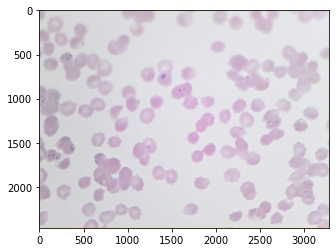

In [20]:
image = PIL.Image.open(io.BytesIO(r.content))
f, ax = plt.subplots(1,1)
ax.imshow(np.array(image))